In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Handwriting to text using pretrained model from huggingface

In [2]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import matplotlib.pyplot as plt
import requests

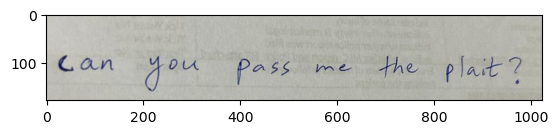

In [22]:
# load image from the IAM database
url = '/kaggle/input/dataaaa/test6.jpg'
image = Image.open(url).convert("RGB")
plt.imshow(image)

In [23]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten')
pixel_values = processor(images=image, return_tensors="pt").pixel_values

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

'can you pass me the plant?'

# Spelling correction

In [46]:
# Import the libraries for processing data and other utilities

import os, sys, gc, warnings
import logging, math, re, heapq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
from collections import Counter    
from nltk.tokenize import word_tokenize

# These settings help in proper formatting and display of the output of code we run
warnings.filterwarnings("ignore")

# This is to download stop words for cleaning the tweets
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
input_file_location = '/kaggle/input/corpus/small.txt'

In [48]:
# We will preprocess the data by reading the file from the default directory and then prepare a list of words in the
# entire corpus, we will also lowercase the words while processing them

# Initiating the word list here
# We will preprocess the data by reading the file from the default directory and then prepare a list of words in the
# entire corpus, we will also lowercase the words while processing them

# Initiating the word list here
words = [] 

# read the file and append words one by one
with open(input_file_location, 'r') as file:
    file_read = file.read()
    pre_process_file = re.findall(r"\w+", file_read)
    word_list = pre_process_file
    for word in word_list:
        words.append(word.lower())
        
# This will be our new vocabulary
vocab = set(words)  



In [49]:
# Initiating the word_count dictionary and populating it
word_count_dict = {}
word_count_dict = Counter(words)
print(f"There are {len(word_count_dict)} key values pairs")


There are 12663 key values pairs


In [50]:
# Initalize the probability dictionary
probs = {} 
total_words = sum(word_count_dict.values())

for word, word_count in word_count_dict.items():
    word_prob = word_count/total_words
    probs[word] = word_prob
print(f"Length of probs is {len(probs)}")

# Let us use both the dictionaries for both word counts and probabilities and display an example word.



Length of probs is 12663


In [51]:
def delete_letter(word):
    delete_list = []
    split_list = []
    split_list = [(word[:i], word[i:]) for i in range(len(word))]
    delete_list = [L+R[1:] for L, R in split_list]
    return delete_list

def switch_letter(word):
    switch_list = []
    split_list = []
    split_list = [(word[:i], word[i:]) for i in range(len(word))]
    switch_list = [L + R[1] + R[0] + R[2:] for L, R in split_list if len(R)>=2]
    return switch_list

def replace_letter(word):
    letters = 'abcdefghijklmnopqrstuvwxyz'
    replace_list = []
    split_list = []
    split_list = [(word[0:i], word[i:]) for i in range(len(word))]
    replace_list = [L + letter + (R[1:] if len(R)>1 else '') for L, R in split_list if R for letter in letters]
    replace_set = set(replace_list)
    replace_list = sorted(list(replace_set))   
    return replace_list

def insert_letter(word):
    letters = 'abcdefghijklmnopqrstuvwxyz'
    insert_list = []
    split_list = []
    split_list = [(word[0:i], word[i:]) for i in range(len(word)+1)]
    insert_list = [L + letter + R for L, R in split_list for letter in letters]
    return insert_list

def edit_one_letter(word, allow_switches = True):
    edit_one_set = set()
    edit_one_set.update(delete_letter(word))
    if allow_switches: edit_one_set.update(switch_letter(word))
    edit_one_set.update(replace_letter(word))
    edit_one_set.update(insert_letter(word))
    if word in edit_one_set: edit_one_set.remove(word)
    return edit_one_set

def edit_two_letter(word, allow_switches = True):
    edit_two_set = set()
    edit_one = edit_one_letter(word, allow_switches=allow_switches)
    for word in edit_one:
        if word:
            edit_two = edit_one_letter(word, allow_switches=allow_switches)
            edit_two_set.update(edit_two)
    
    return edit_two_set


In [52]:
def get_spelling_suggestions(word, probs, vocab, n=2,):    
    suggestions = []
    top_n_suggestions = []
    suggestions = list((word in vocab and word) or 
                       edit_one_letter(word).intersection(vocab) or
                       edit_two_letter(word).intersection(vocab))
    top_n_suggestions = [[s, probs[s]] for s in list(suggestions)]
    return top_n_suggestions


In [53]:
my_words = ['dys','copyrigt','refrane','disdaain','tumtultous']
tmp_corrections = []
for word_c in my_words: 
    tmp_corrections.append(get_spelling_suggestions(word_c, probs, vocab, 3))
for i, word in enumerate(my_words):
    print(' ')
    print(f'Word - {my_words[i]}')
    for j, word_prob in enumerate(tmp_corrections[i]):
        print(f"word - {j}: {word_prob[0]}, probability {word_prob[1]:.6f}")


 
Word - dys
word - 0: days, probability 0.000418
word - 1: dy, probability 0.000006
 
Word - copyrigt
word - 0: copyright, probability 0.000062
 
Word - refrane
word - 0: refrain, probability 0.000006
word - 1: refrained, probability 0.000006
 
Word - disdaain
 
Word - tumtultous
word - 0: tumultuous, probability 0.000006


In [2]:
try:
    import contextualSpellCheck
except:
    ! pip install contextualSpellCheck
    import contextualSpellCheck
    
try:
    import spacy
except:
    ! pip install contextualSpellCheck
    import spacy
 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.6/285.6 kB 13.4 MB/s eta 0:00:00


In [8]:
   
nlp = spacy.load('en_core_web_sm')
contextualSpellCheck.add_to_pipe(nlp,config={"max_edit_dist": 5})
doc = nlp('James is playng on his piano')

print(nlp.pipe_names)
# This shows the number of corrections in the input text.
print(len(doc._.suggestions_spellCheck)) 

# This shows all the actual corrections that were made with the associated mapping.
print(doc._.suggestions_spellCheck)


print(doc._.outcome_spellCheck)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'contextual spellchecker']
1
{playng: 'playing'}
James is playing on his piano


# Grammar error correction

In [27]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
model_name = 'deep-learning-analytics/GrammarCorrector'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(torch_device)

In [28]:
def correct_grammar(input_text,num_return_sequences):
    batch = tokenizer([input_text],truncation=True,padding='max_length',max_length=64, return_tensors="pt").to(torch_device)
    translated = model.generate(**batch,max_length=64,num_beams=4, num_return_sequences=num_return_sequences, temperature=1.5)
    tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
    return tgt_text

In [29]:
text = generated_text
print(correct_grammar(text, num_return_sequences=2))

['can you pass me the plant?', 'can you give me the plant?']
